### Entraînement

#### Partie 4 - Création de l'architecture U-NET et entraînement du model


In [14]:
%matplotlib inline

import random
import numpy as np
import os
import sys
from IPython.display import display
import tensorflow as tf
import datetime
from keras import callbacks
tf.debugging.set_log_device_placement(False)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.generator as gen
import Modules.model as model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

datasets_dir = init.init('U-NET experiments')

<br>**Projet M1 - Détection d'anomalies sur imagerie médicale - U-NET experiments**

Version              : 2
Notebook id          : U-NET experiments
Run time             : Monday 13 February 2023, 01:50:37
Hostname             : DESKTOP-FRB70CL (Windows)
Tensorflow log level : Error only  (=2)
Datasets dir         : C:/Users/Marc/Desktop/DATASET
Run dir              : ./run
Update keras cache   : False
tensorflow           : 2.10.1
tensorflow.keras     : 2.10.0
numpy                : 1.21.5
skimage              : 0.19.2
matplotlib           : 3.5.2
pandas               : 1.4.4


In [16]:
train_img_dir = os.path.join(datasets_dir, 'DATASET', 'Train', 'Images', 'img')
train_mask_dir = os.path.join(datasets_dir, 'DATASET', 'Train', 'Masks', 'img')

test_img_dir = os.path.join(datasets_dir, 'DATASET', 'Test', 'Images', 'img')
test_mask_dir = os.path.join(datasets_dir, 'DATASET', 'Test', 'Masks', 'img')

train_img_list = os.listdir(train_img_dir)
train_img_list.sort()  
train_mask_list = os.listdir(train_mask_dir)
train_mask_list.sort()
train_num_images = len(os.listdir(train_img_dir))

test_img_list = os.listdir(test_img_dir)
test_img_list.sort()  
test_mask_list = os.listdir(test_mask_dir)
test_mask_list.sort()
test_num_images = len(os.listdir(test_img_dir))

print("Nombre total d'images pour l'entraînement : ", train_num_images)
print("Nombre total d'images pour les tests : ", test_num_images)

Nombre total d'images pour l'entraînement :  8710
Nombre total d'images pour les tests :  2490


Nombre de valeurs dans le masque :  [  0 118]
(384, 640, 3) (384, 640)


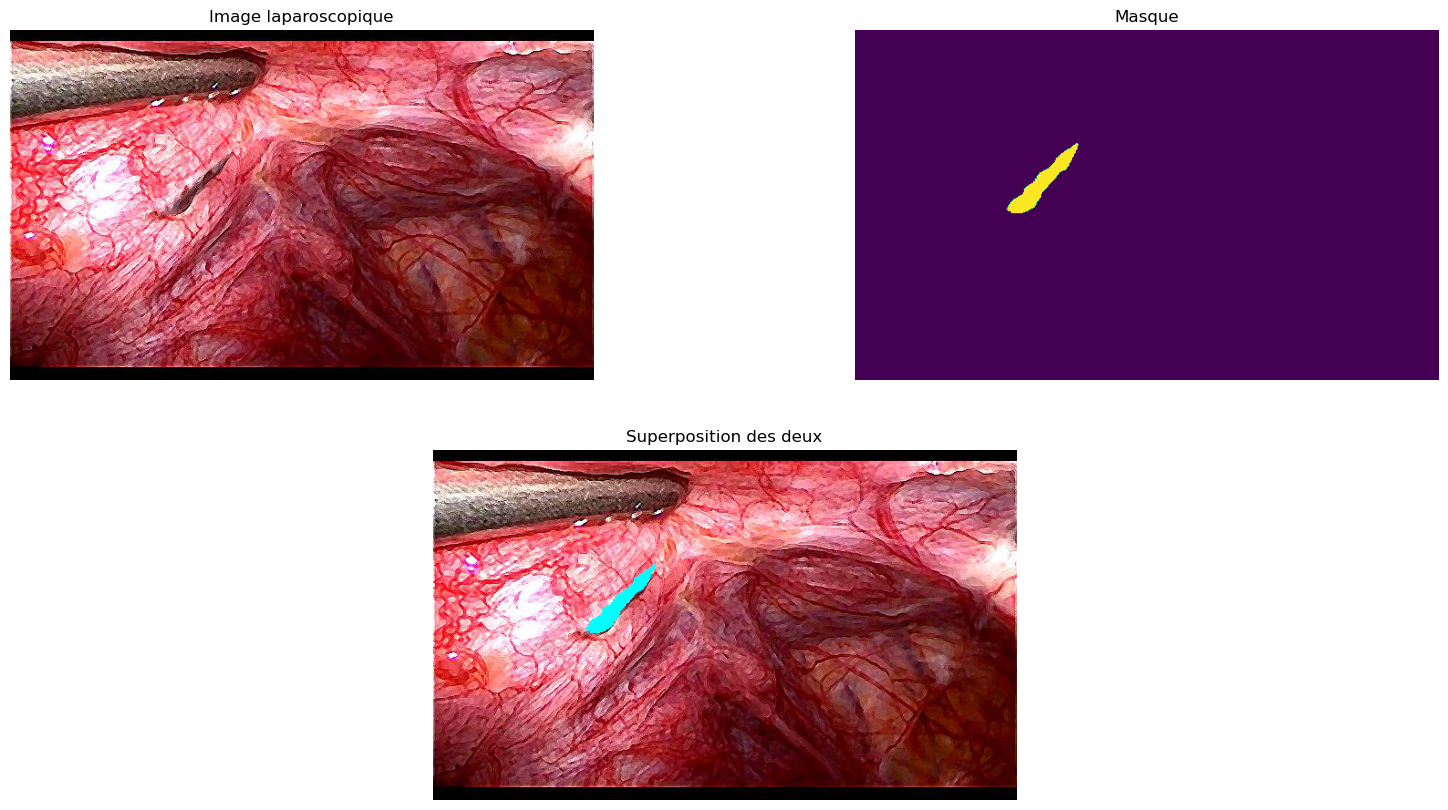

In [17]:
img_num = random.randint(0, train_num_images-1)
img_for_plot = utils.getImgPath(os.path.join(train_img_dir,train_img_list[img_num]))
mask_for_plot = utils.getMaskPath(os.path.join(train_mask_dir,train_mask_list[img_num]))

disp.plot3(img_for_plot, mask_for_plot)
print("Nombre de valeurs dans le masque : ", np.unique(mask_for_plot))
print(img_for_plot.shape, mask_for_plot.shape)

Création d'un générateur de données. En effet, Il nous est impossible de stocker la totalité du dataset en mémoire. Ainsi, nous allons créer un générateur qui va injecter au fur et à mesure de l'entrainement les données.

In [18]:
seed=24
batch_size= 10

train_img_path = os.path.join(datasets_dir, 'DATASET', 'Train', 'Images')
train_mask_path = os.path.join(datasets_dir, 'DATASET', 'Train', 'Masks')
train_img_gen = gen.trainGenerator(train_img_path, train_mask_path, batch_size, seed)

test_img_path = os.path.join(datasets_dir, 'DATASET', 'Test', 'Images')
test_mask_path = os.path.join(datasets_dir, 'DATASET', 'Test', 'Masks')
val_img_gen = gen.trainGenerator(test_img_path, test_mask_path, batch_size, seed)

In [19]:
x, y = train_img_gen.__next__()

Found 8710 images belonging to 1 classes.
Found 8710 images belonging to 1 classes.


(10, 384, 640, 3)
(10, 384, 640, 1)


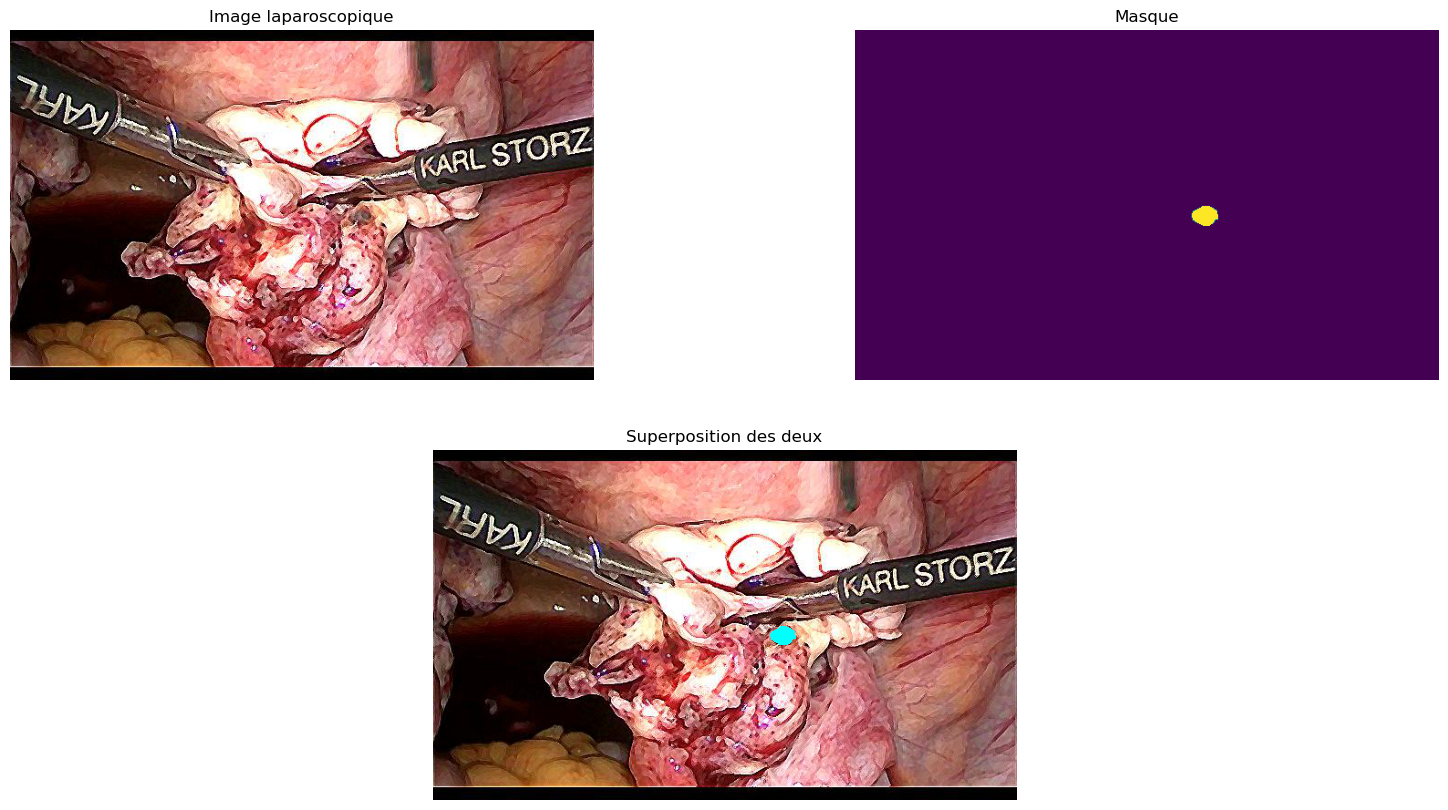

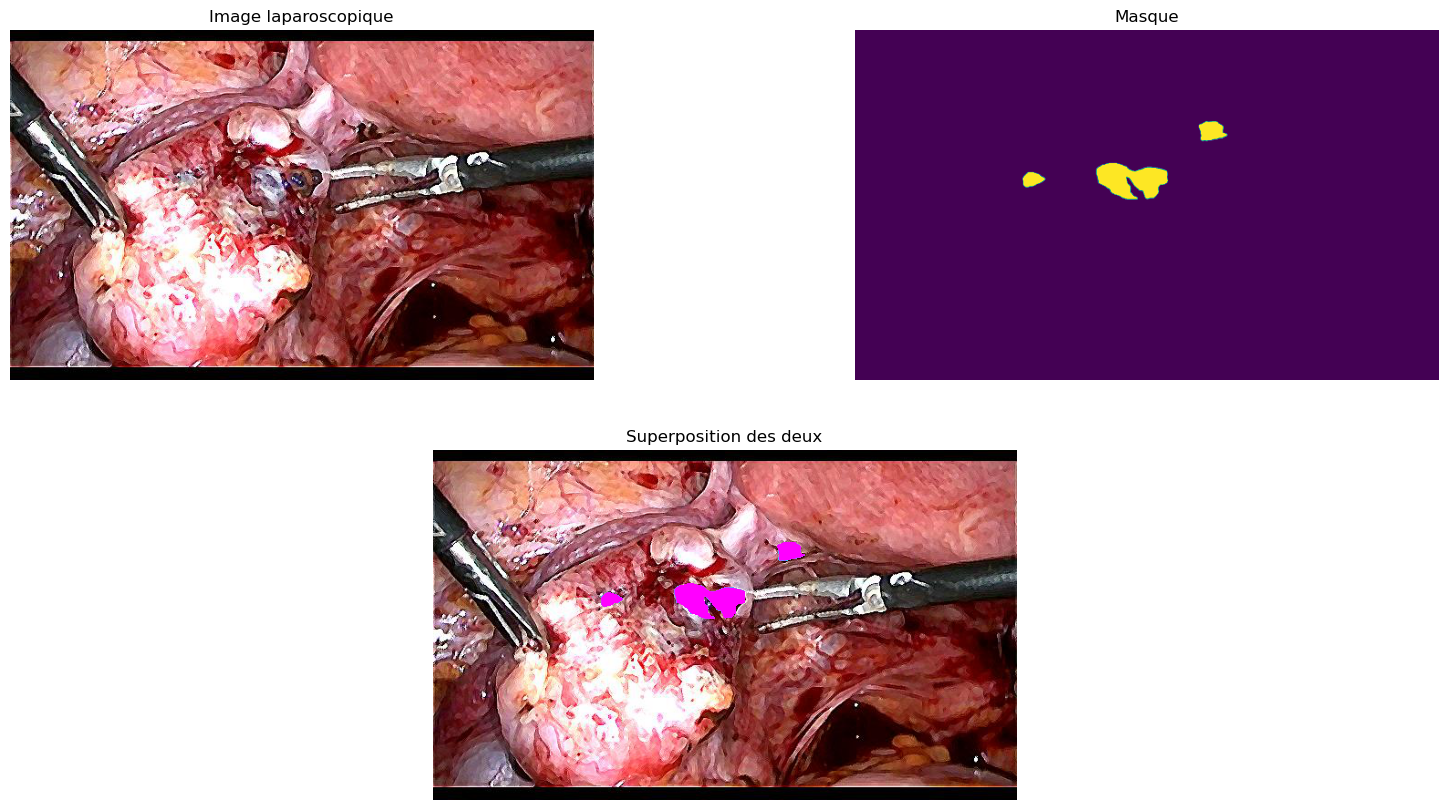

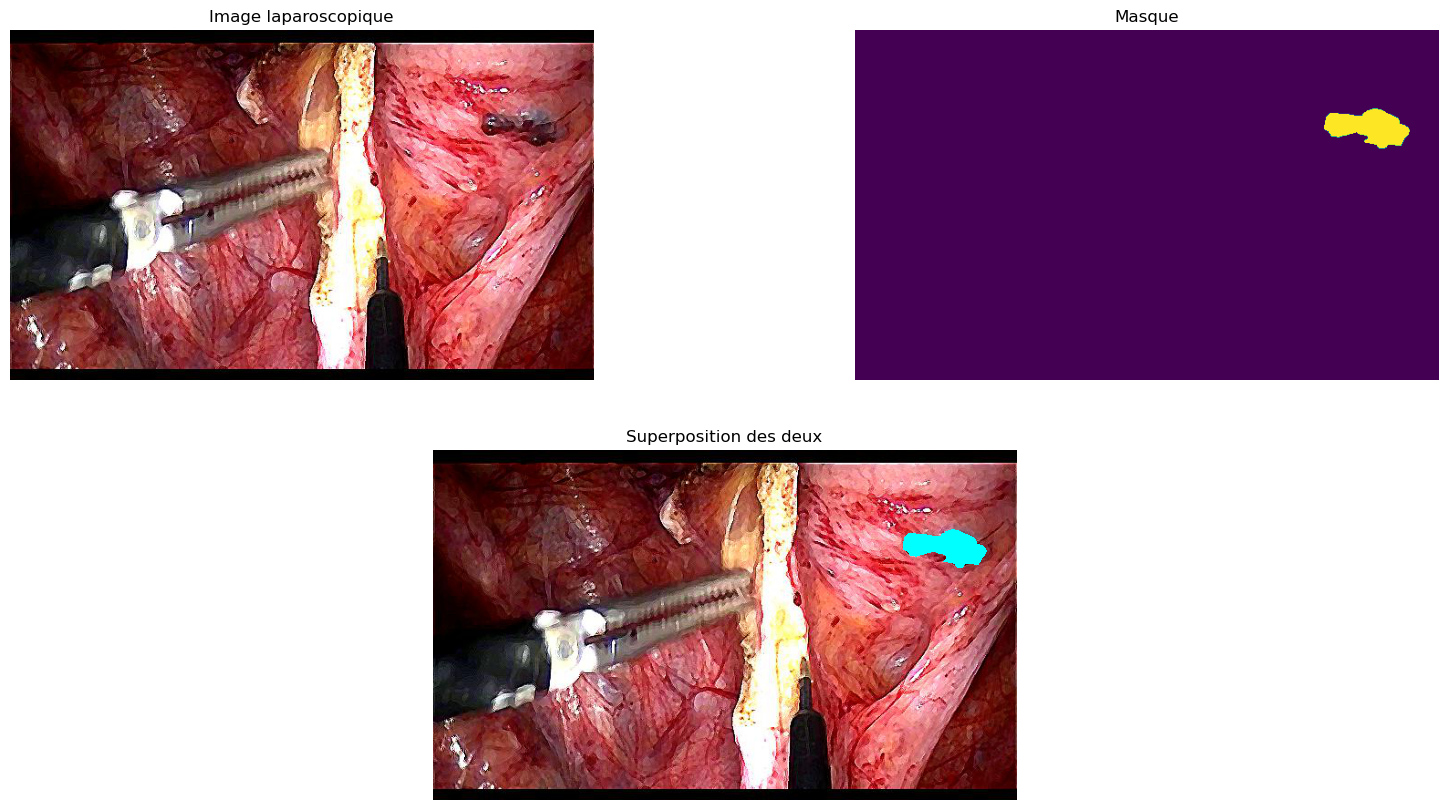

In [20]:
print(x.shape)
print(y.shape)

for i in range(0,3):
    image = x[i,:,:,:]
    mask = y[i,:,:,:]
    disp.plot3(image, mask)

In [21]:
num_train_imgs = len(os.listdir(train_img_dir))
num_val_images = len(os.listdir(test_img_dir))
print("Nombre d'images pour l'entraînement : ", num_train_imgs)
print("Nombre d'images pour les tests : ", num_val_images)
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


Nombre d'images pour l'entraînement :  8710
Nombre d'images pour les tests :  2490


In [22]:
print(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

384 640 3


In [10]:
# mymodel = model.simpleUNET(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# metrics = ['accuracy', 'Precision', 'Recall', model.jacard_coef]

# mymodel.compile(optimizer = 'adam', loss=[model.jacard_coef_loss], metrics=metrics)

#mymodel.summary()

In [11]:
# history=mymodel.fit(train_img_gen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=50,
#           verbose=1,
#           validation_data=val_img_gen,
#           validation_steps=val_steps_per_epoch)

### Pour MARC !!

In [23]:
metrics = ['accuracy', 'Precision', 'Recall', model.jacard_coef]

tf.debugging.set_log_device_placement(False)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
    mymodel = model.simpleUNET(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    mymodel.compile(optimizer='adam', loss=[
                    model.jacard_coef_loss], metrics=metrics)

print(mymodel.input_shape)
print(mymodel.output_shape)

log_dir = "Logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, profile_batch=0)

earlystopping = callbacks.EarlyStopping(monitor='val_jacard_coef',
                                        mode="max", patience=20,
                                        restore_best_weights=True)

checkpoint_filepath = os.path.join(os.curdir, 'Best_Models')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_jacard_coef',
    mode='max',
    save_freq=15,
    save_best_only=True
)

history = mymodel.fit(train_img_gen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=100,
                      verbose=1,
                      validation_data=val_img_gen,
                      validation_steps=val_steps_per_epoch,
                      callbacks=[tensorboard_callback,earlystopping,model_checkpoint_callback]
                      )

mymodel.save('ENDOMETRIOSIS_UNET_SEG.hdf5')

(None, 384, 640, 3)
(None, 384, 640, 1)
Epoch 1/100
871/871 [==============================] - ETA: 0s - loss: -5.9839 - accuracy: 0.7644 - precision: 0.0674 - recall: 0.9432 - jacard_coef: 5.9839Found 2490 images belonging to 1 classes.
Found 2490 images belonging to 1 classes.
871/871 [==============================] - 302s 341ms/step - loss: -5.9839 - accuracy: 0.7644 - precision: 0.0674 - recall: 0.9432 - jacard_coef: 5.9839 - val_loss: -2.3960 - val_accuracy: 0.9560 - val_precision: 0.2790 - val_recall: 0.7077 - val_jacard_coef: 2.3960
Epoch 2/100
871/871 [==============================] - 300s 344ms/step - loss: -8.4650 - accuracy: 0.8473 - precision: 0.1053 - recall: 0.9531 - jacard_coef: 8.4650 - val_loss: -6.2770 - val_accuracy: 0.9504 - val_precision: 0.2819 - val_recall: 0.8552 - val_jacard_coef: 6.2770
Epoch 3/100
871/871 [==============================] - 299s 343ms/step - loss: -10.9316 - accuracy: 0.8798 - precision: 0.1347 - recall: 0.9594 - jacard_coef: 10.9316 - val_l

Epoch 29/100
871/871 [==============================] - 285s 327ms/step - loss: -42.3222 - accuracy: 0.9657 - precision: 0.4855 - recall: 0.9890 - jacard_coef: 42.3222 - val_loss: -39.3409 - val_accuracy: 0.9635 - val_precision: 0.4141 - val_recall: 0.9901 - val_jacard_coef: 39.3409
Epoch 30/100
871/871 [==============================] - 285s 327ms/step - loss: -42.6316 - accuracy: 0.9656 - precision: 0.4858 - recall: 0.9896 - jacard_coef: 42.6316 - val_loss: -32.8728 - val_accuracy: 0.9703 - val_precision: 0.5031 - val_recall: 0.9672 - val_jacard_coef: 32.8728
Epoch 31/100
871/871 [==============================] - 285s 327ms/step - loss: -43.4543 - accuracy: 0.9660 - precision: 0.4921 - recall: 0.9905 - jacard_coef: 43.4542 - val_loss: -32.4644 - val_accuracy: 0.9714 - val_precision: 0.5146 - val_recall: 0.9218 - val_jacard_coef: 32.4644
Epoch 32/100
871/871 [==============================] - 285s 327ms/step - loss: -44.8406 - accuracy: 0.9673 - precision: 0.5093 - recall: 0.9898 - j

Epoch 58/100
871/871 [==============================] - 286s 328ms/step - loss: -54.1413 - accuracy: 0.9711 - precision: 0.5777 - recall: 0.9924 - jacard_coef: 54.1412 - val_loss: -40.0934 - val_accuracy: 0.9748 - val_precision: 0.5867 - val_recall: 0.9190 - val_jacard_coef: 40.0934
Epoch 59/100
871/871 [==============================] - 285s 327ms/step - loss: -55.0113 - accuracy: 0.9713 - precision: 0.5824 - recall: 0.9932 - jacard_coef: 55.0112 - val_loss: -45.1135 - val_accuracy: 0.9731 - val_precision: 0.5805 - val_recall: 0.9863 - val_jacard_coef: 45.1135
Epoch 60/100
871/871 [==============================] - 285s 327ms/step - loss: -54.8349 - accuracy: 0.9715 - precision: 0.5861 - recall: 0.9933 - jacard_coef: 54.8349 - val_loss: -38.6602 - val_accuracy: 0.9712 - val_precision: 0.5415 - val_recall: 0.9693 - val_jacard_coef: 38.6602
Epoch 61/100
871/871 [==============================] - 285s 327ms/step - loss: -54.7683 - accuracy: 0.9710 - precision: 0.5778 - recall: 0.9929 - j

Epoch 87/100
871/871 [==============================] - 285s 328ms/step - loss: -61.0138 - accuracy: 0.9730 - precision: 0.6210 - recall: 0.9946 - jacard_coef: 61.0139 - val_loss: -47.5981 - val_accuracy: 0.9757 - val_precision: 0.5951 - val_recall: 0.9106 - val_jacard_coef: 47.5980
Epoch 88/100
871/871 [==============================] - 285s 327ms/step - loss: -60.0725 - accuracy: 0.9727 - precision: 0.6134 - recall: 0.9945 - jacard_coef: 60.0725 - val_loss: -54.0688 - val_accuracy: 0.9717 - val_precision: 0.5649 - val_recall: 0.9906 - val_jacard_coef: 54.0688
Epoch 89/100
871/871 [==============================] - 286s 329ms/step - loss: -61.2471 - accuracy: 0.9731 - precision: 0.6247 - recall: 0.9949 - jacard_coef: 61.2471 - val_loss: -58.6370 - val_accuracy: 0.9743 - val_precision: 0.5880 - val_recall: 0.9921 - val_jacard_coef: 58.6370
Epoch 90/100
871/871 [==============================] - 285s 327ms/step - loss: -61.1886 - accuracy: 0.9732 - precision: 0.6238 - recall: 0.9944 - j

AttributeError: module 'Modules.model' has no attribute 'save'

In [24]:
mymodel.save('ENDOMETRIOSIS_UNET_SEG.hdf5')